In [1]:
import os
import cv2
import numpy as np
from data_reader import Vocabulary, HWDBDatasetHelper, LMDBReader

root = "/home/alexey/A4/" 
train_path = os.path.join(root, 'train.lmdb')
test_path = os.path.join(root, 'test.lmdb')
gt_path = './gt.txt'

# ResNet18 and ArcFaceLoss

### Data tools

In [3]:
train_reader = LMDBReader(train_path)
train_reader.open()
train_helper = HWDBDatasetHelper(train_reader)

In [4]:
train_helper, val_helper = train_helper.train_val_split()

In [5]:
train_helper.size(), val_helper.size()

(2578433, 644609)

In [6]:
img, label = train_helper.get_item(42)

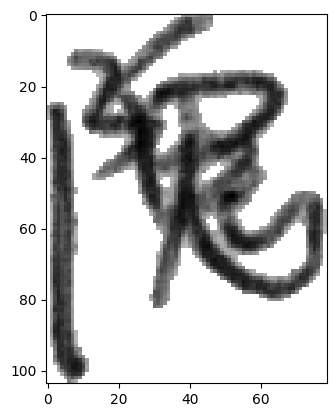

In [7]:
from matplotlib import pyplot as plt
plt.imshow(img, cmap='gray')

In [8]:
img.shape

(104, 79)

In [9]:
import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn

class HWDBDataset(Dataset):
    def __init__(self, helper: HWDBDatasetHelper):
        self.helper = helper
    
    def __len__(self):
        return self.helper.size()
    
    def __getitem__(self, idx):
        img, label = self.helper.get_item(idx)
        return torch.FloatTensor((cv2.resize(img, (128, 128)) - 127.5) / 255.), label

In [10]:
train_dataset = HWDBDataset(train_helper)
val_dataset = HWDBDataset(val_helper)

In [11]:
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### Model & training

In [25]:
from torchvision.models import resnet18
import torch.nn.functional as F

class ResNet(nn.Module):
    def __init__(self, embedding_size=512):
        super().__init__()
        self.resnet18 = resnet18()
        num_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_features, embedding_size)
        
    def forward(self, x):
        x = self.resnet18(x.unsqueeze(1).expand(-1, 3, -1, -1))
        return x

In [60]:
from pytorch_metric_learning import losses

n_classes = train_helper.vocabulary.num_classes()
embedding_size = 512

model = ResNet(embedding_size)
criterion = losses.ArcFaceLoss(num_classes=n_classes, embedding_size=embedding_size)

In [77]:
model_params = sum(p.numel() for p in model.parameters())
criterion_params = sum(p.numel() for p in criterion.parameters())
print("Model params:", model_params)
print("Criterion params:", criterion_params)

Model params: 11439168
Criterion params: 3752960


In [61]:
import lightning
from pytorch_metric_learning import losses

class LitBox(lightning.LightningModule):
    def __init__(self, model, n_classes, embedding_size=512):
        super().__init__()
        self.model = model
        
    def training_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = criterion(outputs, targets)        
        
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch

        outputs = self.model(inputs)
        loss = criterion(outputs, targets)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.model.parameters())
        return optimizer

In [29]:
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping

In [30]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
lit_model = LitBox(model, n_classes, embedding_size)
logger = TensorBoardLogger("tb_logs", name="ResNet")
early_stopping = EarlyStopping('val_loss')
trainer = lightning.Trainer(logger=logger, max_epochs=4, callbacks=[early_stopping])
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [ ]:
%tensorboard --logdir tb_logs

In [75]:
# torch.save(model.state_dict(), "ResNet_weights.pth")
# torch.save(criterion.state_dict(), 'criterion_weights.pth')

In [64]:
# model.load_state_dict(torch.load("ResNet_weights.pth"))
# criterion.load_state_dict(torch.load('criterion_weights.pth'))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# criterion.to(device)

### Evaluation

In [38]:
pred_path = './pred.txt'

test_reader = LMDBReader(test_path)
test_reader.open()
test_helper = HWDBDatasetHelper(test_reader, prefix='Test')

In [39]:
test_dataset = HWDBDataset(test_helper)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
loss = losses.ArcFaceLoss(num_classes=n_classes, embedding_size=embedding_size).to(device)
loss.load_state_dict(torch.load('criterion_weights.pth'))

<All keys matched successfully>

In [ ]:
from tqdm import tqdm

preds = []
model.eval()
with torch.no_grad():
    for X, _ in tqdm(test_loader):
        
        logits = model(X.to(device))
        classes = torch.argmax(loss.get_logits(logits), dim=1).cpu().numpy()
        
        preds.extend(classes)

In [73]:
with open(pred_path, 'w') as f_pred:
    for idx, pred in enumerate(preds):
        name = test_helper.namelist[idx]
        cls = train_helper.vocabulary.class_by_index(pred)
        print(name, cls, file=f_pred)

In [74]:
from course_intro_ocr_t2.evaluate import evaluate

evaluate(gt_path, pred_path)

0.9448876594769247